In [1]:
#1.1.1
# Import SparkConf class into program by using similar code from tutorial
from pyspark import SparkConf
# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"
# The `Assignment 1` shown on the Spark cluster UI page
app_name = "Assignment 1"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
sc = SparkContext.getOrCreate(spark_conf)
sc.setLogLevel('ERROR')

In [2]:
#1.1.2
#Import csv file by using sc.textFile
trip_rdd = sc.textFile('data/trip.csv')

In [3]:
#1.1.3
#Import csv file by using sc.textFile
passenger_rdd = sc.textFile('data/passenger.csv')

In [4]:
#1.1.4
#Remove the header row by using .first() and filter
header_trip = trip_rdd.first()
trip_rdd1 = trip_rdd.filter(lambda x: x != header_trip)
#Remove the header row by using .first() and filter
header_passenger = passenger_rdd.first()
passenger_rdd1 = passenger_rdd.filter(lambda x: x != header_passenger)


In [5]:
#Show 5 records by using .take(5)
trip_rdd1.take(5)

['a84c0db2,cb64172e,2ea4359d,43006,9/8/2019 10:01:28 PM,9/8/2019 10:15:54 PM,0.3,1.92,4.36',
 'a84c2d10,3034e6fe,e1bd0c8d,43006,7/1/2019 8:56:28 PM,7/1/2019 9:22:09 PM,0,9.36,6.91',
 'a84c3e75,93fb6802,75e6d450,43050,8/20/2019 9:30:46 PM,8/20/2019 9:46:48 PM,0,4.39,3.48',
 'a84c3f6f,25fc9273,5ba48e89,43020,9/8/2019 2:42:41 AM,9/8/2019 2:59:56 AM,0,2.04,1.54',
 'a84c5ce2,484c4d0c,fdb2ef59,43006,6/10/2019 9:29:18 AM,6/10/2019 9:55:36 AM,0,7.37,5.83']

In [6]:
passenger_rdd1.take(5)

['00000fab,5/11/2019 8:23:54 PM',
 '0000149d,12/24/2018 9:21:33 PM',
 '00002b66,9/20/2018 9:08:24 PM',
 '00002bc7,7/28/2019 11:27:56 AM',
 '0000332e,2/21/2019 11:34:24 PM']

In [7]:
#1.2.1
#Print default number of partitions by using getNumPartitions()
print('trip_rdd partitions:',trip_rdd.getNumPartitions())
print('passenger_rdd partitions:',passenger_rdd.getNumPartitions())

trip_rdd partitions: 6
passenger_rdd partitions: 2


In [8]:
#1.2.2a
import regex as re
# Implement function with logic to be applied to the RDDs by using similar code from tutorial
def parseRecord122a(line):
    # Split line separated by comma
    array_line = line.split(',')
    # Choose only index 1 for key and call_time and id for value
    return (array_line[1], [array_line[1],array_line[0]])


map_passenger_rdd122a = passenger_rdd1.map(parseRecord122a)
map_passenger_rdd122a = map_passenger_rdd122a.map(lambda x: (re.sub('.*2019.*','In 2019',x[0]),x[1]))
map_passenger_rdd122a = map_passenger_rdd122a.map(lambda x: (re.sub('^((?!2019).)*$','Not in 2019',x[0]),x[1]))


In [9]:
map_passenger_rdd122a.filter(lambda x: x[0] == 'In 2019').take(5)

[('In 2019', ['5/11/2019 8:23:54 PM', '00000fab']),
 ('In 2019', ['7/28/2019 11:27:56 AM', '00002bc7']),
 ('In 2019', ['2/21/2019 11:34:24 PM', '0000332e']),
 ('In 2019', ['8/2/2019 8:01:07 AM', '000048aa']),
 ('In 2019', ['7/11/2019 3:39:47 AM', '0000497f'])]

In [10]:
map_passenger_rdd122a.filter(lambda x: x[0] == 'Not in 2019').take(5)

[('Not in 2019', ['12/24/2018 9:21:33 PM', '0000149d']),
 ('Not in 2019', ['9/20/2018 9:08:24 PM', '00002b66']),
 ('Not in 2019', ['11/3/2017 4:44:59 AM', '00003af1']),
 ('Not in 2019', ['3/9/2018 9:10:11 AM', '00004a41']),
 ('Not in 2019', ['10/14/2018 2:19:04 AM', '00008cd6'])]

In [11]:
#1.2.2b
spark = SparkSession(sc)
#Convert rdd to dataframe
#Fix error by https://stackoverflow.com/questions/32788387/pipelinedrdd-object-has-no-attribute-todf-in-pyspark
hasattr(map_passenger_rdd122a, "toDF")
map_passenger_rdd122b = map_passenger_rdd122a.map(lambda x: (x[0],x[1][0],x[1][1]))
df_122b = map_passenger_rdd122b.toDF()

#Repartition by range using first column because it already divide by In 2019 and Not in 2019
df_range122b = df_122b.repartitionByRange("_1")

In [12]:
#1.2.2c
from pyspark.rdd import RDD

#Adjust the print partition code from tutorial to show only number of record in each partition

def print_partitions(data):
    if isinstance(data, RDD):
        numPartitions = data.getNumPartitions()
        partitions = data.glom().collect()
    else:
        numPartitions = data.rdd.getNumPartitions()
        partitions = data.rdd.glom().collect()
    
    print(f"NUMBER OF PARTITIONS: {numPartitions}")
    for index, partition in enumerate(partitions):
        # show partition even have 0 record
        if len(partition) >= 0:
            print(f"Partition {index}: {len(partition)} records")

            
print_partitions(df_range122b)

NUMBER OF PARTITIONS: 3
Partition 0: 556856 records
Partition 1: 678926 records
Partition 2: 0 records


In [13]:
#1.3.1
# Implement function with logic to be applied to the RDDs by using similar code from tutorial
def parseRecord131(line):
    # Split line separated by comma
    array_line = line.split(',')
    # Select id trip_distance and surge_rate column
    return (array_line[0], array_line[6],array_line[7])

map_trip_rdd131 = trip_rdd1.map(parseRecord131)
#Count before filtering
map_trip_rdd131.count()

2318357

In [14]:
map_trip_rdd131.take(5)

[('a84c0db2', '0.3', '1.92'),
 ('a84c2d10', '0', '9.36'),
 ('a84c3e75', '0', '4.39'),
 ('a84c3f6f', '0', '2.04'),
 ('a84c5ce2', '0', '7.37')]

In [15]:
#Remvoe null from trip_distance and surge_rate remove
rdd_131 = map_trip_rdd131.filter(lambda x: x[1] == '' or x[2] == '')
#Count after filtering
rdd_131.count()

23245

In [16]:
#1.3.2
# Implement function similar to 1.3.1
def parseRecord(line):
    # Split line separated by comma
    array_line = line.split(',')   
    # Choose only index 3 and 6 for this rdd
    return (array_line[3], array_line[6])

map_trip_rdd132 = trip_rdd1.map(parseRecord)
map_trip_rdd132 = map_trip_rdd132.filter(lambda x: x[1] != '')
map_trip_rdd132 = map_trip_rdd132.map(lambda x: (x[0],float(x[1])))

#Using the code from
#https://stackoverflow.com/questions/29930110/calculating-the-averages-for-each-key-in-a-pairwise-k-v-rdd-in-spark-with-pyth
#to groupby and find average for each city id
map_trip_rdd132 = map_trip_rdd132.aggregateByKey((0,0),lambda a,b:(a[0]+b,a[1] +1),lambda a,b:(a[0]+b[0],a[1]+b[1]))
map_trip_rdd132.mapValues(lambda v: v[0]/v[1]).collect()


[('43020', 0.03601068571614701),
 ('43050', 0.05548070794570697),
 ('43278', 0.022855663068084002),
 ('43116', 0.05953757146336632),
 ('43006', 0.03493899396743278),
 ('43179', 0.07074122889438615)]

In [17]:
#1.3.3
def parseRecord133(line):
    # Split line separated by comma
    array_line = line.split(',')    
    # Choose only driver id and trip_distance for this rdd
    return array_line[2],array_line[7]

map_trip_rdd133 = trip_rdd1.map(parseRecord133)

#Filter null out of rdd.If the column have null.It cannot convert to float.
map_trip_rdd133 = map_trip_rdd133.filter(lambda x: x[1] != '' )
#Convert distance column to float
map_trip_rdd133 = map_trip_rdd133.map(lambda x: (x[0],float(x[1])))
#Filter negative value out of rdd
map_trip_rdd133 = map_trip_rdd133.filter(lambda x: x[1] > 0)

In [18]:
#Find max distance value
map_trip_rdd133.max(lambda x:x[1])

('771e01b2', 296.1)

In [19]:
#The max driver id is 771e01b2
map_trip_rdd133.filter(lambda x: x[0] == '771e01b2').collect()

[('771e01b2', 296.1)]

In [20]:
#Find min distance value
map_trip_rdd133.min(lambda x:x[1])

('bc087229', 0.01)

In [21]:
#The min driver id is bc087229
map_trip_rdd133.filter(lambda x: x[0] == 'bc087229').collect()

[('bc087229', 0.01),
 ('bc087229', 2.88),
 ('bc087229', 1.17),
 ('bc087229', 5.24),
 ('bc087229', 6.73),
 ('bc087229', 1.73),
 ('bc087229', 3.23),
 ('bc087229', 1.17),
 ('bc087229', 4.42),
 ('bc087229', 3.04),
 ('bc087229', 3.63),
 ('bc087229', 1.65),
 ('bc087229', 2.83)]

In [22]:
#2.1.1
#Read 3 csv files into dataframes
df_trip = spark.read.csv("data/trip.csv",header=True,inferSchema=True)
df_passenger = spark.read.csv("data/passenger.csv",header=True,inferSchema=True)
df_city = spark.read.csv("data/city.csv",header=True,inferSchema=True)

In [23]:
#2.1.2
#Using printScheme to display schema
df_trip.printSchema()
df_passenger.printSchema()
df_city.printSchema()

root
 |-- id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- call_time: string (nullable = true)
 |-- finish_time: string (nullable = true)
 |-- surge_rate: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_fare: double (nullable = true)

root
 |-- id: string (nullable = true)
 |-- first_call_time: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)



In [24]:
#2.2.1
#Rename the id column by using withColumnRenamed()
df_city = df_city.withColumnRenamed('id', 'city_id')
df_city.show()

+-------+------------+
|city_id|        name|
+-------+------------+
|  42868|      Mordor|
|  42948|      Erebor|
|  43006|Minas Tirith|
|  43020|    Isengard|
|  43050|      Gondor|
|  43094|       Moria|
|  43116|       Rohan|
|  43179|   Rivendell|
|  43244| Minas Ithis|
|  43278|   The Shire|
+-------+------------+



In [25]:
#2.2.2
#Join by using .join() at df_city.city_id and df_trip.city_id
#Also drop duplicate city_id column and change column 'name' to 'city'
df_222 = df_city.join(df_trip,df_city.city_id==df_trip.city_id).drop(df_city.city_id).withColumnRenamed('name', 'city')
df_222.show()

+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+
|        city|      id|driver_id|passenger_id|city_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|
+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|  43006|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d|  43006| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|  43050|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89|  43020| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|  43006|6/10/2019 9:29:18 AM|6

In [26]:
#2.2.3
#Using filter to find trip_distance and trip_fare that larger than 0
df_223 =df_222.filter((df_222.trip_distance > 0) & (df_222.trip_fare > 0))
df_223.show(5)

+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+
|        city|      id|driver_id|passenger_id|city_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|
+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|  43006|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d|  43006| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|  43050|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89|  43020| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|  43006|6/10/2019 9:29:18 AM|6

In [27]:
#2.2.4
#Using .sort() and ascending=False at to trip_distance to sort by descending order
df_223.select('id','driver_id','passenger_id','trip_distance').sort(df_223.trip_distance, ascending=False).show(5)

+--------+---------+------------+-------------+
|      id|driver_id|passenger_id|trip_distance|
+--------+---------+------------+-------------+
|7f4a1ec5| 704642b5|    771e01b2|        296.1|
|30bb5f34| 7119b481|    d5e5e5d8|       261.71|
|ac1861e1| ceccad76|    2a2f3fc5|       244.82|
|4525a2bf| bdb22ca4|    b7f9f488|       236.14|
|b60c4614| 70b9733e|    09ec3959|       235.42|
+--------+---------+------------+-------------+
only showing top 5 rows



In [28]:
#2.3.1
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType,BooleanType
from datetime import datetime

#Create function to extract only month/day/year to new column
def extract_year(s):
    return re.findall('\d/\d+/\d\d\d\d',s)

#First Register the function as UDF
extract_year_udf = udf(extract_year)

#Call the function
df_231 = df_222.select(df_222['*'],extract_year_udf('call_time').alias("date"))

#Remove bracket date column
#Refer to https://stackoverflow.com/questions/71827270/pyspark-regexp-replace-and-replace-it-with-captured-group 
#https://stackoverflow.com/questions/48283924/remove-replace-characters-using-pyspark
#and https://stackoverflow.com/questions/62613949/replace-parentheses-in-pyspark-with-replace-regex
df_231 = df_231.withColumn("date", F.regexp_replace(F.regexp_replace(F.regexp_replace("date", "\\]\\[", "-"), "\\[", ""), "\\]", ""))
#Change '/' to '-'
df_231 = df_231.withColumn('date', F.regexp_replace('date', '/', '-'))


#Change date column datatype by to_date
#Some part of following code from https://stackoverflow.com/questions/57742725/get-weekday-name-from-date-in-pyspark-python
#And https://stackoverflow.com/questions/62943941/to-date-fails-to-parse-date-in-spark-3-0 to avoid error
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
from pyspark.sql.functions import dayofweek
df_231 = df_231.withColumn("date", F.to_date(("date"), "MM-dd-yyyy"))
df_231 = df_231.withColumn("date", dayofweek(("date")))

In [29]:
#Create On holiday column
#If the value in the day column equal to 1 or 7. It mean weekend = 1,true. If 2=6. It mean weekday = 0,false
df_231 = df_231.withColumn("Bool", F.when(df_231.date == 1, 1).when(df_231.date == 7, 1).when((df_231.date > 1) &  (df_231.date <7),0))
df_231 = df_231.drop(df_231.date)
#Change column name and datatype to BooleanType
df_231 = df_231.withColumn("Bool",df_231.Bool.cast(BooleanType()))
df_231 = df_231.withColumnRenamed('Bool', 'On holiday')
df_231.show()

+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+----------+
|        city|      id|driver_id|passenger_id|city_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|On holiday|
+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+----------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|  43006|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|      true|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d|  43006| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|     false|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|  43050|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|     false|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89|  43020| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|      true|

In [30]:
#2.3.2
#Using groupby() and avg on trip_fare column than sort at city column
df_231.groupBy("city","On holiday").avg("trip_fare").sort(df_231.city, ascending=True).show()

+------------+----------+------------------+
|        city|On holiday|    avg(trip_fare)|
+------------+----------+------------------+
|      Gondor|      true| 5.286176159118884|
|      Gondor|     false| 5.063437871283693|
|    Isengard|     false| 5.429138635957776|
|    Isengard|      true|5.7977057073445595|
|Minas Tirith|      true| 5.132205116975108|
|Minas Tirith|     false| 4.897181695636764|
|   Rivendell|      true| 5.689150440097405|
|   Rivendell|     false| 5.662984016023205|
|       Rohan|     false| 5.211337160029305|
|       Rohan|      true| 5.414882787994826|
|   The Shire|      true| 5.104217215922054|
|   The Shire|     false| 4.948454726841958|
+------------+----------+------------------+



In [31]:
#Using spark sql with similar syntax with Dataframes
#select only city, On holiday column and avg by trip_fare
#group by city and On holiday
df_231.createOrReplaceTempView("sql_231")
sql_232 = spark.sql('''
  SELECT city,`On holiday`,avg(trip_fare)
  FROM sql_231   
  GROUP BY city,`On holiday`
  ORDER BY city
''')
sql_232.show()

+------------+----------+------------------+
|        city|On holiday|    avg(trip_fare)|
+------------+----------+------------------+
|      Gondor|     false| 5.063437871283693|
|      Gondor|      true| 5.286176159118884|
|    Isengard|     false| 5.429138635957776|
|    Isengard|      true|5.7977057073445595|
|Minas Tirith|      true| 5.132205116975108|
|Minas Tirith|     false| 4.897181695636764|
|   Rivendell|      true| 5.689150440097405|
|   Rivendell|     false| 5.662984016023205|
|       Rohan|      true| 5.414882787994826|
|       Rohan|     false| 5.211337160029305|
|   The Shire|      true| 5.104217215922054|
|   The Shire|     false| 4.948454726841958|
+------------+----------+------------------+



In [32]:
#2.3.3
#Using similar method to 2.3.1
extract_year_udf = udf(extract_year)

#Call the function and create weekday column
df_233 = df_222.select(df_222['*'],extract_year_udf('call_time').alias("day"))
df_233 = df_233.withColumn("day", F.regexp_replace(F.regexp_replace(F.regexp_replace("day", "\\]\\[", "-"), "\\[", ""), "\\]", ""))
df_233 = df_233.withColumn('day', F.regexp_replace('day', '/', '-'))

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
#Using to_date function
df_233 = df_233.withColumn("day", F.to_date(("day"), "MM-dd-yyyy"))

#Using date_format with E to change int to name of the day
#Some part of following code from https://stackoverflow.com/questions/57742725/get-weekday-name-from-date-in-pyspark-python
df_233 = df_233.withColumn("day", F.date_format('day','E'))

#Using upper to convert all string to uppercase
from pyspark.sql.functions import upper
df_233 = df_233.select('*',upper('day').alias('weekday')).drop('day')
#Show top 5 row
df_233.show(5)

+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+-------+
|        city|      id|driver_id|passenger_id|city_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|weekday|
+------------+--------+---------+------------+-------+--------------------+--------------------+----------+-------------+---------+-------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|  43006|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|    SUN|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d|  43006| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|    MON|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|  43050|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|    TUE|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89|  43020| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|    SUN|
|Minas Tirith|a84c5c

In [33]:
#2.3.4
#Using sql to create table that have total number of trip for each day from each city
df_233.createOrReplaceTempView("df_233")
sql_t_1 = spark.sql('''
  SELECT city,weekday,count(*)
  FROM df_233   
  GROUP BY city,weekday
  ORDER BY city,weekday
''')
sql_t_1 = sql_t_1.select(sql_t_1["city"],sql_t_1["weekday"],sql_t_1['count(1)'].alias('Count'))

In [34]:
#Using sql to create table that have total number of trip for each city
sql_t_2 = spark.sql('''
  SELECT city,count(*)
  FROM df_233   
  GROUP BY city
  ORDER BY city
''')
sql_t_2 = sql_t_2.select(sql_t_2["city"].alias('city2'),sql_t_2['count(1)'].alias('Count2'))

In [35]:
#Join both new table
df_234 = sql_t_1.join(sql_t_2,sql_t_1.city==sql_t_2.city2,how='outer').drop(sql_t_2.city2)
#The percentage will calculate by (total count for each day from each city/total number of trip for each city)*100
df_234 = df_234.select('*',((df_234.Count/df_234.Count2)*100).alias('Percentage'))
#Select required column and sort by city,weekday
df_234 = df_234.select(df_234.city,df_234.weekday,df_234.Count,df_234.Percentage).sort(df_234.city,df_234.weekday, ascending=True)
df_234.show()

+------------+-------+-----+------------------+
|        city|weekday|Count|        Percentage|
+------------+-------+-----+------------------+
|      Gondor|    FRI|45623|14.324377784545634|
|      Gondor|    MON|45502|14.286387084417848|
|      Gondor|    SAT|51117|16.049343953984156|
|      Gondor|    SUN|52755| 16.56363128298676|
|      Gondor|    THU|42607|13.377436035905921|
|      Gondor|    TUE|39995| 12.55733926951105|
|      Gondor|    WED|40900| 12.84148458864863|
|    Isengard|    FRI|49305|14.602485428612047|
|    Isengard|    MON|43823| 12.97890110410842|
|    Isengard|    SAT|57867|17.138262332369806|
|    Isengard|    SUN|55741|16.508612519546983|
|    Isengard|    THU|46326|13.720205657963321|
|    Isengard|    TUE|41060|12.160593280576222|
|    Isengard|    WED|43526|12.890939676823201|
|Minas Tirith|    FRI|61216|14.613686007233317|
|Minas Tirith|    MON|53856|12.856682462192195|
|Minas Tirith|    SAT|69616|16.618961792334595|
|Minas Tirith|    SUN|67379|16.084937752

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Gondor'),
  Text(1, 0, 'Isengard'),
  Text(2, 0, 'Minas Tirith'),
  Text(3, 0, 'Rivendell'),
  Text(4, 0, 'Rohan'),
  Text(5, 0, 'The Shire')])

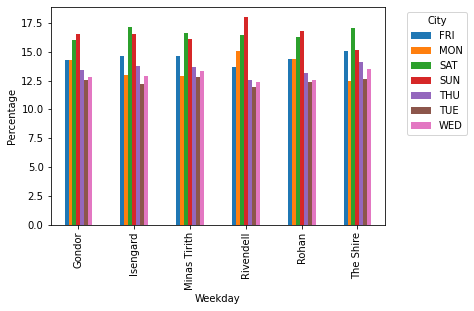

In [36]:
#2.3.5
#Convert data to pandas library
DF_pd = df_234.toPandas()
import matplotlib.pyplot as plt
#Create bar graph
df235 = DF_pd.pivot(index='city', columns='weekday', values='Percentage')
df235.plot.bar()
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Weekday')
plt.ylabel('Percentage')
plt.xticks()

In [37]:
#All of the city have number of trip at weekend more than weekday.
#Monday and tuesday have the least number of trip.

In [38]:
%%time
#3 rdd

city_rdd = sc.textFile('data/city.csv')
# remove the header row
header_city = city_rdd.first()
city_rdd1 = city_rdd.filter(lambda x: x != header_city)

#Map the data for trip.csv
def parseTrip(line):
    array_line = line.split(',')
    return (array_line[3],array_line[0])

map_trip_rdd3 = trip_rdd1.map(parseTrip)


#Map the data for city.csv
def parseCity(line):
    array_line = line.split(',')    
    return (array_line[0],array_line[1])

map_city_rdd1 = city_rdd1.map(parseCity)
#Join the table by first column which is id and city name 
map_city_rdd1 = map_trip_rdd3.join(map_city_rdd1).map(lambda x: (x[1]))


#Map the data that have id and call time column
def parseTrip2(line):
    array_line = line.split(',')    
    return (array_line[0],array_line[4])


map_trip_rdd3 = trip_rdd1.map(parseTrip2)

#Join the table by first column which is id
#Select name and call_time column in lambda
map_joined = map_city_rdd1.join(map_trip_rdd3).map(lambda x: (x[0],(x[1][0]),(x[1][1])))
map_joined.filter(lambda x: x[1] == 'Minas Tirith').take(5)  

CPU times: user 46.5 ms, sys: 16.3 ms, total: 62.8 ms
Wall time: 43.9 s


[('a84d29a0', 'Minas Tirith', '8/11/2019 9:49:49 PM'),
 ('a8570182', 'Minas Tirith', '7/21/2019 8:45:22 PM'),
 ('a86b4a74', 'Minas Tirith', '9/2/2019 6:19:24 AM'),
 ('a871a177', 'Minas Tirith', '8/5/2019 12:58:07 PM'),
 ('a87acabf', 'Minas Tirith', '9/23/2019 6:26:36 AM')]

In [39]:
%%time
#3 Dataframes
#Using join and identify df_city.city_id==df_trip.city_id
df_3 = df_city.join(df_trip,df_city.city_id==df_trip.city_id)
#Select only id name and call_time column
df_3.select(['id','name','call_time']).filter(df_3['name'] == 'Minas Tirith').show()

+--------+------------+--------------------+
|      id|        name|           call_time|
+--------+------------+--------------------+
|a84c0db2|Minas Tirith|9/8/2019 10:01:28 PM|
|a84c2d10|Minas Tirith| 7/1/2019 8:56:28 PM|
|a84c5ce2|Minas Tirith|6/10/2019 9:29:18 AM|
|a84ceb22|Minas Tirith|6/30/2019 3:09:18 AM|
|a84d29a0|Minas Tirith|8/11/2019 9:49:49 PM|
|a84d31ee|Minas Tirith|7/7/2019 11:53:51 PM|
|a84d8d16|Minas Tirith|6/24/2019 7:25:16 AM|
|a84dbd8a|Minas Tirith| 7/1/2019 9:56:52 PM|
|a84dc20a|Minas Tirith|6/13/2019 2:42:58 AM|
|a84dfcb7|Minas Tirith|7/27/2019 6:19:44 PM|
|a84f80fa|Minas Tirith| 8/2/2019 8:17:11 PM|
|a84fc521|Minas Tirith|5/14/2019 4:48:25 AM|
|a850834f|Minas Tirith|7/30/2019 8:37:40 AM|
|a850c3de|Minas Tirith|8/12/2019 12:49:3...|
|a850de4c|Minas Tirith|6/4/2019 10:49:11 PM|
|a851b2b2|Minas Tirith|8/28/2019 10:52:4...|
|a8528280|Minas Tirith|8/27/2019 6:51:21 AM|
|a852a3b2|Minas Tirith|8/31/2019 4:36:57 AM|
|a8530202|Minas Tirith|8/31/2019 8:25:22 AM|
|a8537774|

In [40]:
%%time
#3 sql
#Create tempview
df_trip.createOrReplaceTempView("df_t")
df_city.createOrReplaceTempView("df_c")
#Using left join and identify df_t.city_id==df_c.city_id and sort only 'Minas Tirith' in name
sql_3 = spark.sql('''
  SELECT id,name,call_time
  FROM df_t d LEFT JOIN df_c c   
  ON d.city_id=c.city_id
  WHERE name == 'Minas Tirith'
''')
sql_3.show()

+--------+------------+--------------------+
|      id|        name|           call_time|
+--------+------------+--------------------+
|a84c0db2|Minas Tirith|9/8/2019 10:01:28 PM|
|a84c2d10|Minas Tirith| 7/1/2019 8:56:28 PM|
|a84c5ce2|Minas Tirith|6/10/2019 9:29:18 AM|
|a84ceb22|Minas Tirith|6/30/2019 3:09:18 AM|
|a84d29a0|Minas Tirith|8/11/2019 9:49:49 PM|
|a84d31ee|Minas Tirith|7/7/2019 11:53:51 PM|
|a84d8d16|Minas Tirith|6/24/2019 7:25:16 AM|
|a84dbd8a|Minas Tirith| 7/1/2019 9:56:52 PM|
|a84dc20a|Minas Tirith|6/13/2019 2:42:58 AM|
|a84dfcb7|Minas Tirith|7/27/2019 6:19:44 PM|
|a84f80fa|Minas Tirith| 8/2/2019 8:17:11 PM|
|a84fc521|Minas Tirith|5/14/2019 4:48:25 AM|
|a850834f|Minas Tirith|7/30/2019 8:37:40 AM|
|a850c3de|Minas Tirith|8/12/2019 12:49:3...|
|a850de4c|Minas Tirith|6/4/2019 10:49:11 PM|
|a851b2b2|Minas Tirith|8/28/2019 10:52:4...|
|a8528280|Minas Tirith|8/27/2019 6:51:21 AM|
|a852a3b2|Minas Tirith|8/31/2019 4:36:57 AM|
|a8530202|Minas Tirith|8/31/2019 8:25:22 AM|
|a8537774|

In [41]:
#the rdd was the slowest with total time 32ms
#the sql method was the fastest with 2.02 ms and dataframes method at 6.15 ms still faster than rdd method.